The goal of this notebook is to build a simple, end-to-end prototype for how we will be modeling the V1-MT motion perception pipeline:
- Generate a drifting sinusodial stimulus
- Compute local motion energy signals with a bank of Gabor Filters to simulate V1 complex cell outputs
- Generate a synthentic spike train from a Poisson process (this will be replaced with real MT data in the actual model)
- Fit a Poisson GLM, using the motion energy features, to the single, synthetic MT neuron
- Show that we can recover the synthetic spike train


Actual experimental conditions from the paper where the MT recordings are from:

> Monkeys sat in a primate chair (Crist Instruments) and faced a 55 inch LCD (LG) display (resolution = 1920 × 1080p, refresh rate = 60Hz, background luminance − 26.49 cd/m2) that was corrected to have a linear gamma function. Monkeys viewed the stimulus from a distance of 118cm such that the screen subtended 100 degrees of visual angle.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve
from numpy.typing import NDArray
from matplotlib.animation import FuncAnimation
%matplotlib inline
%load_ext autoreload
%autoreload 2


# Drifting sinusoidal grating

## 2D Sinusoidals

In [5]:
def sinusoidal_2d(
    x: NDArray[np.floating],
    y: NDArray[np.floating],
    theta: float,
    A: float,
    f: float,
    phase: float,
) -> NDArray[np.floating]:
    # TODO: What is a typical domain used in real world stimuli?
    # TODO: What is an intuitive way to understand when frequency, time buckets and time constants
    #       in this context? 
    X, Y = np.meshgrid(x, y)
    X_rot = X * np.cos(theta) + Y * np.sin(theta) 
    return A * np.cos((2 * np.pi * f * X_rot) + phase)

def render_sinusodial_2d(sinusodial: NDArray[np.floating], title: str):
    plt.figure()
    plt.imshow(sinusodial, cmap='gray', origin='lower')
    plt.colorbar()
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Intensity')
    plt.show()

def test_sinusoidal_2d():
    L = 1 
    x, y = np.linspace(0, L, 100), np.linspace(0, L, 100)
    theta = np.pi / 4
    A = 1.0
    f = 4
    phase = 0.0
    sinusodial = sinusoidal_2d(x, y, theta, A, f, phase)
    render_sinusodial_2d(sinusodial, f'A basic 2D sinusodial oriented at {theta}')

Define a function to calculate the pixel pitch (deg / px) given a viweing distance, monitor resolution and monitor length. This allows us to accurately map the psychophysical definition of a stimulus or filter (i.e in visual degrees) to the quantized, pixel lattice we construct. 

## 3D drifting grating stimulus

In [19]:
from motionenergy import drifting_sinusoidal, utils
from IPython.display import HTML, display

def create_and_render_stimulus():
    speed = 5.0 # degrees/s
    size = (20.0, 20.0) # degrees
    theta = 45 # degrees
    spatial_frequency = 0.3 # cycle/deg
    amplitude = 1.0
    time = 5.0 # seconds
    fps = 60 # Hz
    monitor_resolution = (500, 500)
    viewing_distance = 100 # cm
    monitor_length = 20 # in

    # Calculate the degrees / px and the px / inch (dpi)
    (px_pitch, dpi) = utils.pixel_pitch(
        viewing_distance,
        monitor_resolution,
        monitor_length,
    )

    print(f"Calculated pixel pitch: {px_pitch} and dpi: {dpi}")
    stimulus = drifting_sinusoidal.new_stimulus(
        speed,
        size,
        theta,
        0, # phase
        spatial_frequency,
        amplitude,
        time,
        fps,
        px_pitch
    )

    width, height = stimulus.shape[1], stimulus.shape[2]
    print(f"Returned stimulus of size: {stimulus.shape}")

    return drifting_sinusoidal.animate_stimulus(
        stimulus,
        int(np.ceil(fps*time)), # number of frames
        fps,
        width,
        height,
        dpi,
        'Drifting Sinusoidal'
    )

ani = create_and_render_stimulus()
display(HTML(ani.to_jshtml()))


Calculated pixel pitch: 0.041162460204278085 and dpi: 35
Calculated width and height of stimulus in pixels as: 486, 486
Returned stimulus of size: (300, 486, 486)


# Compute local motion energy with a bank of filters

30
--> plotting 30 kernels
--> plotting 6 rows with 5 plots per row


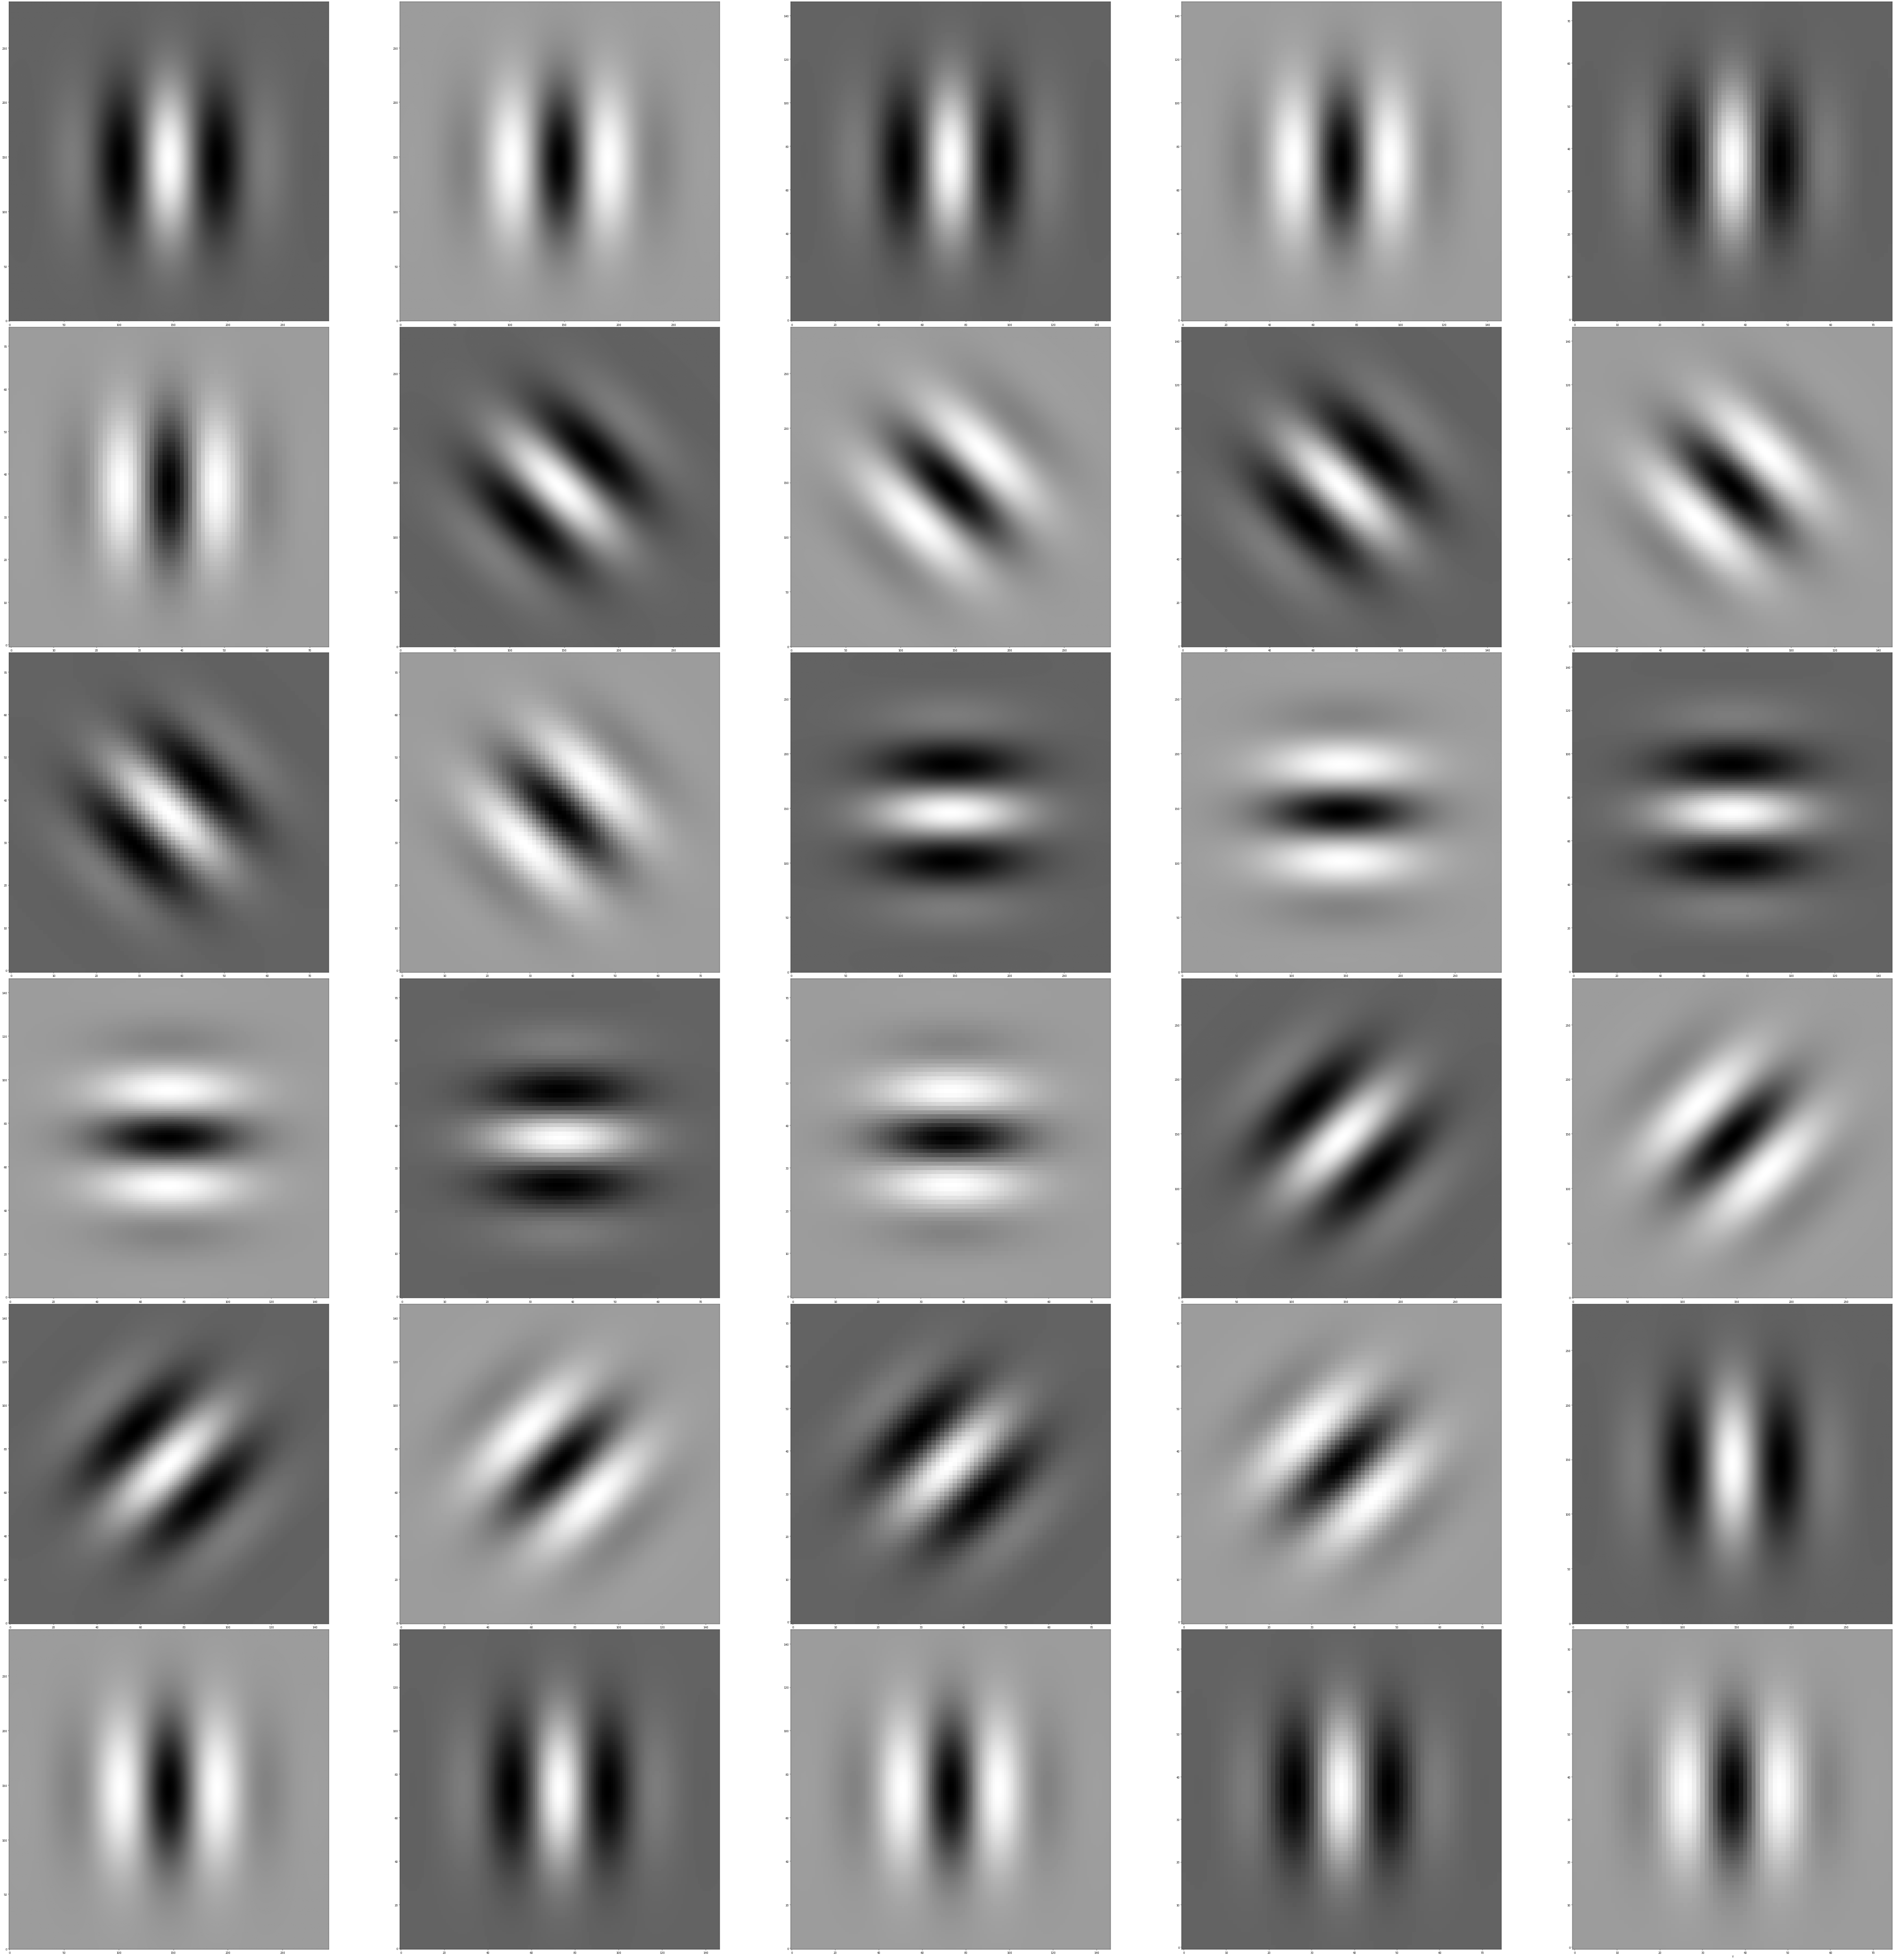

In [51]:
from motionenergy import gabor, utils

def test_single_spatial_filter():
    theta = np.pi / 4
    f_s = 0.3      # cyc/deg  → σ = 0.5
    k = gabor.new_spatial_filter(theta, 0, f_s, 0.02)
    print(k.shape)  # expect ≈ (151, 151)  because 6σ / 0.02 ≈ 150 px

    g = gabor.new_spatial_filter(theta_deg=45,
                                phase=0,
                                f_s=4,
                                pixel_pitch=0.03)   # ≈ 34 px per deg

    print(g.shape)                  # (k, k) with k odd (e.g. 29×29)
    print(g.mean())                 # ≈ 0
    print(np.sqrt((g**2).sum()))    # 1.0

def test_spatial_gabor_filter():
    monitor_resolution = (500, 500)
    viewing_distance = 100 # cm
    monitor_length = 20 # in
    px_pitch, dpi = utils.pixel_pitch(viewing_distance, monitor_resolution, monitor_length)     # deg/px
    thetas = [0, 45, 90, 135, 180]
    frequencies = [0.25, 0.5, 1] # cycles/deg
    phases = [0, np.pi]

    gabors = []
    for theta in thetas:
        for f in frequencies:
            for phase in phases:
                filter = gabor.new_spatial_filter(theta, phase, f, px_pitch) 
                gabors.append(filter)

    # gabors = np.array(gabors)
    print(len(gabors))
    gabor.plot_spatial_gabors(gabors, dpi, 'Spatial Gabors')

# test_single_spatial_filter()
test_spatial_gabor_filter()



In [20]:
import numpy as np
from motionenergy import gabor, utils, energy, drifting_sinusoidal
from IPython.display import HTML, display

monitor_resolution = (100, 100)
viewing_distance = 100 # cm
monitor_length = 20 # in
px_pitch, dpi = utils.pixel_pitch(viewing_distance, monitor_resolution, monitor_length)     # deg/px
print(f"using pixel pitch: {px_pitch} and dpi: {dpi}")

# static stimulus: no temporal drift to test spatial-phase invariance
speed_deg_sec = 0.0  # no drift
size_deg = (5.0, 5.0)
orientation_deg = 45.0
f_s_cpd = 0.5  # cycles / deg
amplitude = 1.0
time = 1.0  # s
fps = 60.0  # Hz
px_pitch = 0.02  # deg / pixel

# generate two stimuli differing only by spatial phase
phase_1 = 0.0
phase_2 = np.pi / 2
stimulus_1 = drifting_sinusoidal.new_stimulus(speed_deg_sec, size_deg, orientation_deg,
                                                phase_1, f_s_cpd, amplitude, time, fps, px_pitch, log_clock_time=True)
ani_1 = drifting_sinusoidal.animate_stimulus(stimulus_1, int(fps * time), fps, stimulus_1.shape[1], stimulus_1.shape[2], dpi, "Stimulus #1")
display(HTML(ani_1.to_jshtml()))

stimulus_2 = drifting_sinusoidal.new_stimulus(speed_deg_sec, size_deg, orientation_deg,
                                                phase_2, f_s_cpd, amplitude, time, fps, px_pitch, log_clock_time=True)
ani_2 = drifting_sinusoidal.animate_stimulus(stimulus_2, int(fps * time), fps, stimulus_2.shape[1], stimulus_2.shape[2], dpi, "Stimulus #1")
display(HTML(ani_2.to_jshtml()))


    

using pixel pitch: 0.20581208857082636 and dpi: 7
Calculated width and height of stimulus in pixels as: 250, 250
new_stimulus took 0.091061s | spatial_frequency=0.5, fps=60.0, px_pitch=0.02


Calculated width and height of stimulus in pixels as: 250, 250
new_stimulus took 0.136248s | spatial_frequency=0.5, fps=60.0, px_pitch=0.02


# Debugging why the spatial invariance test is failing

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
--> plotting 2 kernels
--> plotting 1 rows with 2 plots per row


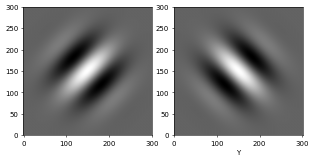

Calculated width and height of stimulus in pixels as: 250, 250
new_stimulus took 0.001048s | spatial_frequency=0.5, fps=1.0, px_pitch=0.02
Calculated width and height of stimulus in pixels as: 250, 250
new_stimulus took 0.000560s | spatial_frequency=0.5, fps=1.0, px_pitch=0.02
[compute_features] found max kernel size as: 751
[compute_features] took 2.057870s | num_frequencies=3, num_thetas=4, px_pitch=0.02
[compute_features] outputting energy of shape (1, 12)


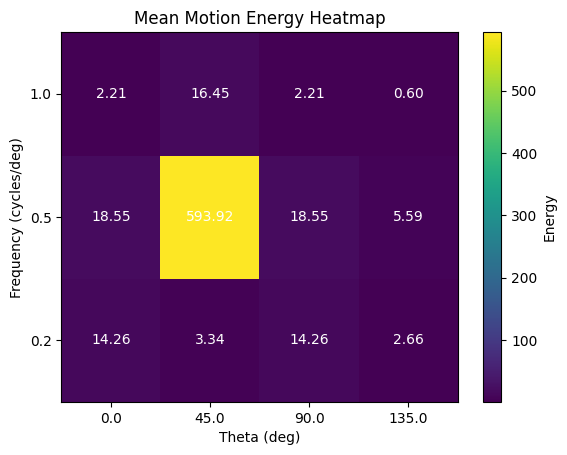

[compute_features] found max kernel size as: 751
[compute_features] took 1.467453s | num_frequencies=3, num_thetas=4, px_pitch=0.02
[compute_features] outputting energy of shape (1, 12)


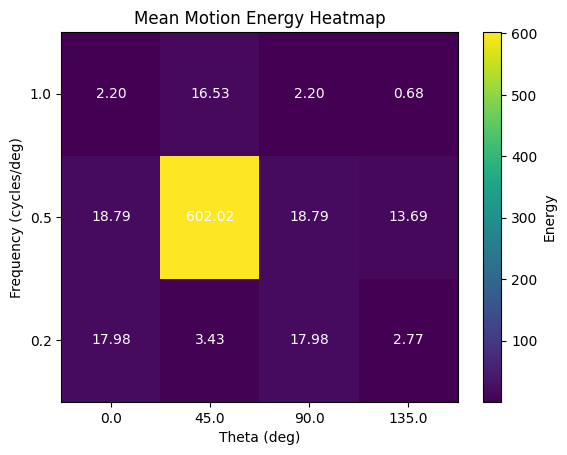

AssertionError: root mean squared error was: 8.101340196618821

In [18]:
from tests import test_motion_energy
from motionenergy import gabor
%load_ext autoreload
%autoreload 2

filter_1 = gabor.new_spatial_filter(135, 0, 0.5, 0.02)
filter_2 = gabor.new_spatial_filter(45, 0, 0.5, 0.02)
gabor.plot_spatial_gabors([filter_1, filter_2], 50, 'Gabors')

ani = test_motion_energy.test_motion_energy_spatial_phase_invariance()
display(HTML(ani.to_jshtml()))


# Generate synthetic spikes from a Poisson process with hard-coded weights 


# Fit a Poisson GLM to the synthetic spikes to recover the real weights 